# King County Sales Assessment

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ShuffleSplit
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

C:\Users\harri\AppData\Local\Temp\ipykernel_14964\423486115.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
# Import data
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Baseline Models

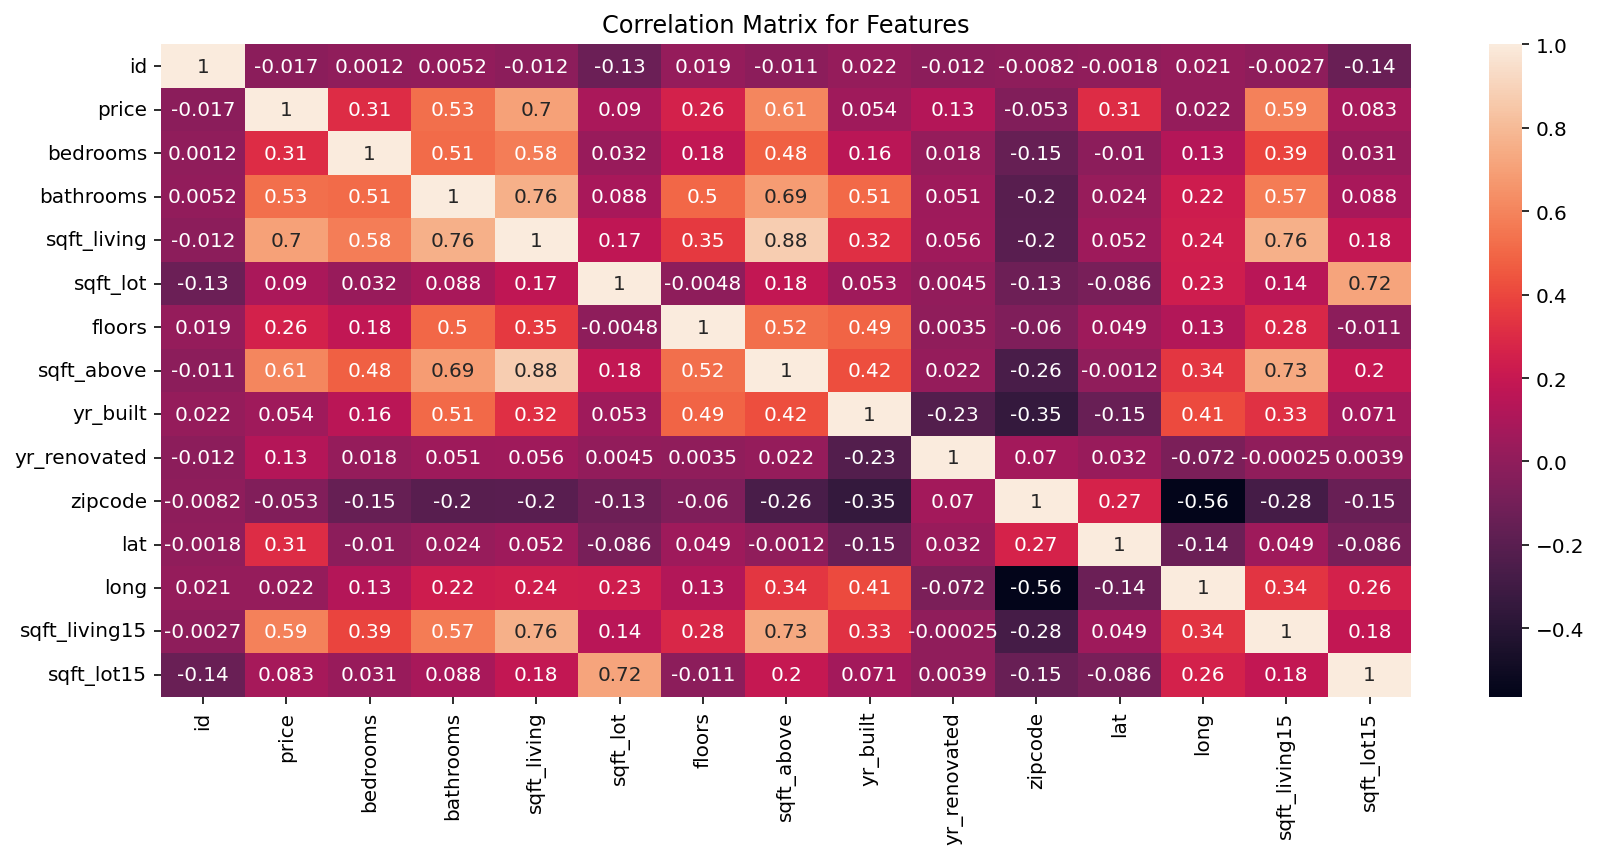

In [5]:
# Lets throw up a heat map to see our simple correlation matrix
plt.figure(figsize=(14, 6))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Matrix for Features')
plt.show()

In [6]:
# putting price in the logarithmic scale raises r squared coefficients later on, done here for efficiency
df['l_price'] = np.log(df['price'])

In [7]:
# log scaling the living space square footage does not change the r squared much, but mitigates both kurtosis and skewness later
df['sqft_living_trans'] = np.log(df['sqft_living'])

In [8]:
# Grade is ordinal, so here we convert the column values to a 1-10 scale, rather than the 3-13 with trailing string
df['grade_final'] = df.grade.map(lambda x: int(x[0]))
# we dont use Grade in the final model, but I feel it is pertinent to show an example of the data exploration I did on different types of variables 

In [9]:
# Drop NA values to least common denominator to allow for most comparisons across same size columns
df_clean = df.dropna(axis = 0, how = 'any')

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15762 entries, 1 to 21596
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15762 non-null  int64  
 1   date               15762 non-null  object 
 2   price              15762 non-null  float64
 3   bedrooms           15762 non-null  int64  
 4   bathrooms          15762 non-null  float64
 5   sqft_living        15762 non-null  int64  
 6   sqft_lot           15762 non-null  int64  
 7   floors             15762 non-null  float64
 8   waterfront         15762 non-null  object 
 9   view               15762 non-null  object 
 10  condition          15762 non-null  object 
 11  grade              15762 non-null  object 
 12  sqft_above         15762 non-null  int64  
 13  sqft_basement      15762 non-null  object 
 14  yr_built           15762 non-null  int64  
 15  yr_renovated       15762 non-null  float64
 16  zipcode            157

In [11]:
# Create dummies for categorical variables
df_dum = pd.get_dummies(df_clean, columns = ['waterfront', 'zipcode'], drop_first = True)

In [12]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15762 entries, 1 to 21596
Data columns (total 92 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15762 non-null  int64  
 1   date               15762 non-null  object 
 2   price              15762 non-null  float64
 3   bedrooms           15762 non-null  int64  
 4   bathrooms          15762 non-null  float64
 5   sqft_living        15762 non-null  int64  
 6   sqft_lot           15762 non-null  int64  
 7   floors             15762 non-null  float64
 8   view               15762 non-null  object 
 9   condition          15762 non-null  object 
 10  grade              15762 non-null  object 
 11  sqft_above         15762 non-null  int64  
 12  sqft_basement      15762 non-null  object 
 13  yr_built           15762 non-null  int64  
 14  yr_renovated       15762 non-null  float64
 15  lat                15762 non-null  float64
 16  long               157

In [13]:
df_dum.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'l_price', 'sqft_living_trans',
       'grade_final', 'waterfront_YES', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipc

In [14]:
# Establish baseline model for strong predictor, ZIP code
X1, y1 = df_dum.drop(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'l_price', 'grade_final', 'sqft_living_trans',
       'waterfront_YES'], axis=1), df_dum['l_price']
X1 = sm.add_constant(X1)
baseline = sm.OLS(y1, X1).fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     259.3
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:27:14   Log-Likelihood:                -6249.8
No. Observations:               15762   AIC:                         1.264e+04
Df Residuals:                   15692   BIC:                         1.318e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.4593      0.023    551.867      0.000      12.415      12.504
zipcode_98002    -0.1222      0.037     -3.286      0.001      -0.195      -0.049
zipcode_98003     0.0649      0.033      1.950      0.051      -0.000       0.130
zipcode_98004     1.5554      0.033     47.497      0.000       1.491       1.620
zipcode_98005     1.1061      0.039     28.397      0.000       1.030       1.182
zipcode_98006     1.1063      0.029     37.513      0.000       1.048       1.164
zipcode_98007     0.8330      0.042     19.652      0.000       0.750       0.916
zipcode_98008     0.8220      0.033     24.593      0.000       0.756       0.887
zipcode_98010     0.4028      0.049      8.280      0.000       0.307       0.498
zipcode_98011     0.6168      0.038     16.227      0.000       0.542       0.691
zipcode_98014     0.5051      0.044     11.567      0.000       0.420       0.591
zipcode_98019     0.4711      0.039     12.063      0.000       0.395       0.548
zipcode_98022     0.1400      0.036      3.929      0.000       0.070       0.210
zipcode_98023     0.0598      0.029      2.037      0.042       0.002       0.117
zipcode_98024     0.6744      0.052     12.859      0.000       0.572       0.777
zipcode_98027     0.7855      0.031     25.678      0.000       0.726       0.845
zipcode_98028     0.5432      0.034     16.191      0.000       0.477       0.609
zipcode_98029     0.8183      0.032     25.476      0.000       0.755       0.881
zipcode_98030     0.1299      0.035      3.737      0.000       0.062       0.198
zipcode_98031     0.1292      0.034      3.809      0.000       0.063       0.196
zipcode_98032    -0.0612      0.043     -1.433      0.152      -0.145       0.023
zipcode_98033     1.0219      0.030     33.697      0.000       0.962       1.081
zipcode_98034     0.6184      0.029     21.364      0.000       0.562       0.675
zipcode_98038     0.2934      0.028     10.326      0.000       0.238       0.349
zipcode_98039     2.0415      0.064     31.805      0.000       1.916       2.167
zipcode_98040     1.4342      0.034     42.407      0.000       1.368       1.500
zipcode_98042     0.1538      0.029      5.343      0.000       0.097       0.210
zipcode_98045     0.4572      0.036     12.624      0.000       0.386       0.528
zipcode_98052     0.8831      0.029     30.801      0.000       0.827       0.939
zipcode_98053     0.8830      0.031     28.643      0.000       0.823       0.943
zipcode_98055     0.1197      0.034      3.511      0.000       0.053       0.187
zipcode_98056     0.4033      0.031     13.164      0.000       0.343       0.463
zipcode_98058     0.2606      0.030      8.640      0.000       0.201       0.320
zipcode_98059     0.5620      0.030     18.673      0.000       0.503       0.621
zipcode_98065     0.6681      0.033     20.212   

''

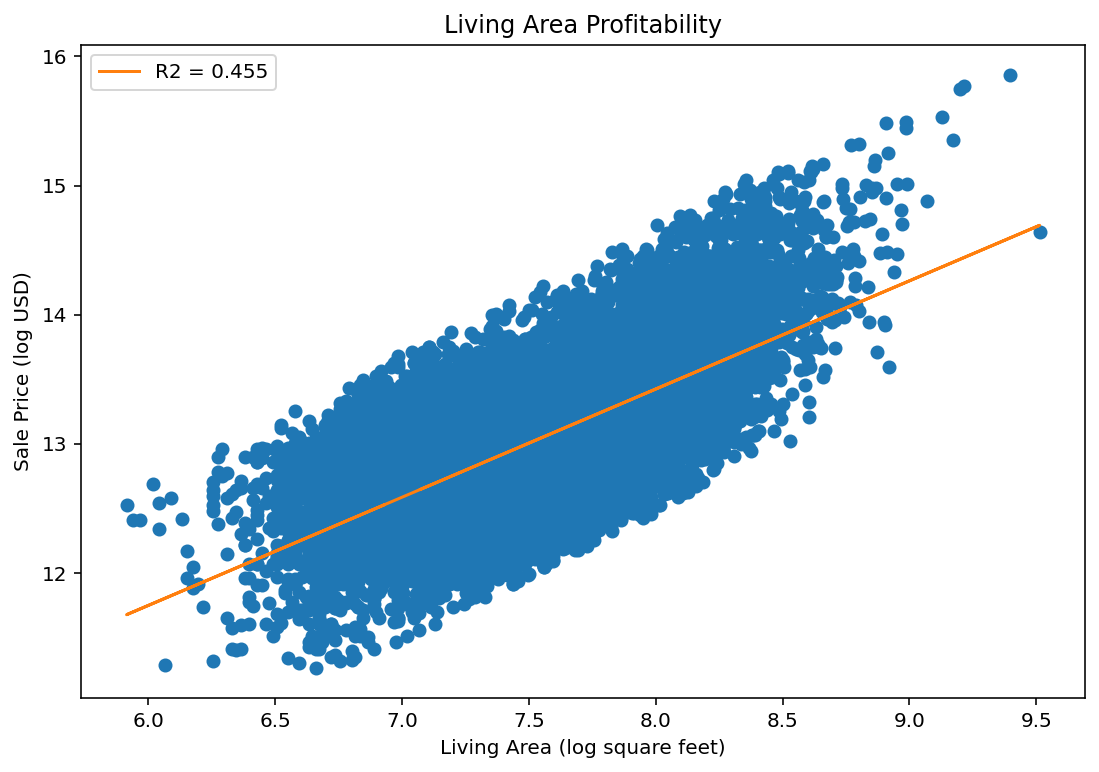

In [15]:
X2, y2 = df['sqft_living_trans'], df['l_price']
plt.figure(figsize=(9,6))

plt.plot(X2, y2, 'o')

# get m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(X2, y2, 1)

# add linear regression line to scatterplot 
plt.plot(X2, m*X2+b, label = 'R2 = 0.455')

plt.title('Living Area Profitability')
plt.xlabel('Living Area (log square feet)')
plt.ylabel('Sale Price (log USD)')
plt.legend()
;

# Final Model

In order to cut down on unnecessary code as per the guidelines, I omit the model summaries for multiple regressions that included grade and waterfront status in favor of the final model. Adding grade as an ordinal predictor does not increase the accuracy of the model at all, and mildly increases skewness. I do not currently 


In [16]:
# Assign final predictors and dependent variable
X, y = df_dum.drop(['id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'l_price',
            'sqft_living', 'grade_final'
       ], axis=1), df_dum['l_price']

In [17]:
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1100.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:27:15   Log-Likelihood:                 1842.6
No. Observations:               15762   AIC:                            -3541.
Df Residuals:                   15690   BIC:                            -2989.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.0687      0.036    193.898      0.000       6.997       7.140
sqft_living_trans     0.7215      0.005    159.209      0.000       0.713       0.730
waterfront_YES        0.7775      0.020     38.195      0.000       0.738       0.817
zipcode_98002        -0.0225      0.022     -1.009      0.313      -0.066       0.021
zipcode_98003         0.0504      0.020      2.528      0.011       0.011       0.089
zipcode_98004         1.2464      0.020     63.295      0.000       1.208       1.285
zipcode_98005         0.8406      0.023     35.966      0.000       0.795       0.886
zipcode_98006         0.7950      0.018     44.779      0.000       0.760       0.830
zipcode_98007         0.7109      0.025     28.011      0.000       0.661       0.761
zipcode_98008         0.7069      0.020     35.312      0.000       0.668       0.746
zipcode_98010         0.3217      0.029     11.047      0.000       0.265       0.379
zipcode_98011         0.4649      0.023     20.418      0.000       0.420       0.510
zipcode_98014         0.4127      0.026     15.784      0.000       0.361       0.464
zipcode_98019         0.3407      0.023     14.566      0.000       0.295       0.387
zipcode_98022         0.1654      0.021      7.757      0.000       0.124       0.207
zipcode_98023         0.0124      0.018      0.706      0.480      -0.022       0.047
zipcode_98024         0.5467      0.031     17.412      0.000       0.485       0.608
zipcode_98027         0.5806      0.018     31.640      0.000       0.545       0.617
zipcode_98028         0.4369      0.020     21.744      0.000       0.397       0.476
zipcode_98029         0.6645      0.019     34.525      0.000       0.627       0.702
zipcode_98030         0.0654      0.021      3.144      0.002       0.025       0.106
zipcode_98031         0.0905      0.020      4.458      0.000       0.051       0.130
zipcode_98032         0.0022      0.026      0.087      0.931      -0.048       0.052
zipcode_98033         0.8646      0.018     47.571      0.000       0.829       0.900
zipcode_98034         0.5826      0.017     33.627      0.000       0.549       0.617
zipcode_98038         0.1929      0.017     11.335      0.000       0.160       0.226
zipcode_98039         1.4980      0.039     38.852      0.000       1.422       1.574
zipcode_98040         1.0419      0.020     51.134      0.000       1.002       1.082
zipcode_98042         0.1055      0.017      6.125      0.000       0.072       0.139
zipcode_98045         0.4041      0.022     18.640      0.000       0.362       0.447
zipcode_98052         0.7031      0.017     40.889      0.000       0.669       0.737
zipcode_98053         0.6697      0.018     36.204      0.000       0.633       0.706
zipcode_98055         0.1627      0.020      7.970      0.000       0.123

In [18]:
# Prepare train and test data from X and y variables for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [19]:
# Inspect residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test
print(train_residuals)
print(test_residuals)

18060    0.091455
4178    -0.018608
13219    0.082941
2839    -0.266770
5520     0.256757
           ...   
7129     0.031156
18336    0.246032
7384    -0.242698
1159    -0.580698
9955     0.115760
Name: l_price, Length: 12609, dtype: float64
8446     0.379067
7473    -0.238393
20534    0.142403
5063     0.147336
17989   -0.215431
           ...   
2330    -0.024277
10260    0.106158
16786    0.203038
8159     0.079904
10136    0.255806
Name: l_price, Length: 3153, dtype: float64


In [20]:
# Determine MSE
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.04624036654907834
Test Mean Squarred Error: 0.04704959588781619


''

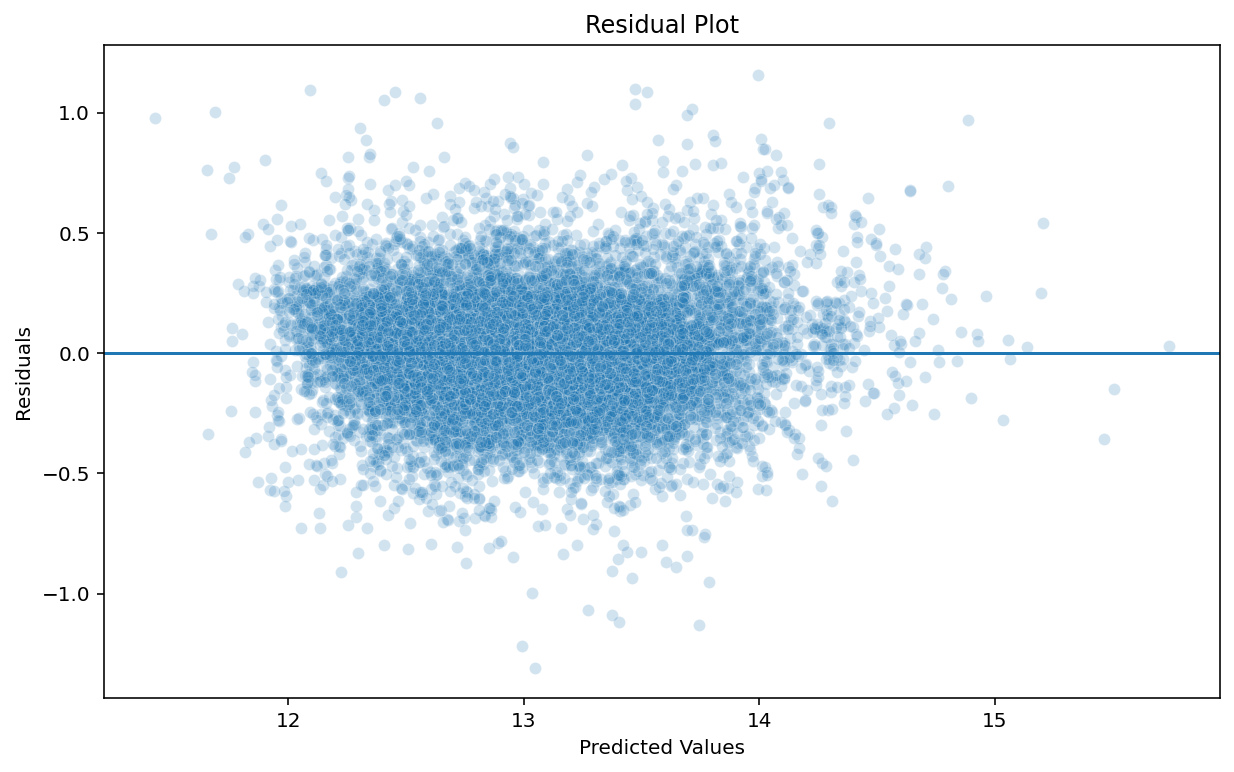

In [21]:
# Create a residual plot to explore possible patterns
df_dum["predicted"] = model1.predict(X)
df_dum["residuals"] = model1.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_dum, x="predicted", y="residuals", alpha = 0.2)
plt.axhline(y=0)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
;

In [22]:
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(estimator=linreg, X=X_train, y=y_train, return_train_score=True, cv=splitter)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8354967482802792
Validation score: 0.8314829925222368
